<a href="https://colab.research.google.com/github/cristianpandele/huggingface_audio/blob/main/Huggingface_Audio_Course.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Install Dependencies

In [ ]:
!pip install -qqqq datasets[audio]
!pip install -qqqq gradio
!pip install -qqqq evaluate jiwer
!pip install -qqqq accelerate
!pip install -qqqq transformers[torch]
!pip install -qqqq speechbrain
!pip install -qqqq transformers
!pip install -qqqq soundfile

# 1. Imports

In [ ]:
from datasets import load_dataset, DatasetDict
from datasets import Audio as DatasetAudio
from transformers import pipeline
from transformers import AutoProcessor, SeamlessM4TModel
from transformers import AutoFeatureExtractor
from transformers import AutoModelForAudioClassification
from transformers import TrainingArguments
from transformers import Trainer
import numpy as np
import torch
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio

/usr/local/lib/python3.10/dist-packages/transformers/deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(


## 1.1. Hub Login

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## 1.2. Get Runtime Info

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Mon May  6 10:07:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   44C    P8              12W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# 2. Exercise

## 2.1. Load Dataset

In [ ]:
vox = load_dataset("facebook/voxpopuli", name="en_accented", split="test", streaming=True)
vox

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for facebook/voxpopuli contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/facebook/voxpopuli
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  wa

IterableDataset({
    features: ['audio_id', 'language', 'audio', 'raw_text', 'normalized_text', 'gender', 'speaker_id', 'is_gold_transcript', 'accent'],
    n_shards: 1
})

## 2.2. Select Third Dataset Entry

In [ ]:
vox = vox.skip(2)
iterator = iter(vox)

third_entry = next(iterator)
third_entry

{'audio_id': '20181115-0900-PLENARY-en_20181115-11:18:17_3',
 'language': 16,
 'audio': {'path': 'test_part_0/20181115-0900-PLENARY-en_20181115-11:18:17_3.wav',
  'array': array([ 0.03717041,  0.08773804,  0.12280273, ..., -0.11514282,
         -0.08380127, -0.09283447]),
  'sampling_rate': 16000},
 'raw_text': 'The job constitution there is nothing about a free',
 'normalized_text': 'the job constitution there is nothing about a free',
 'gender': 'na',
 'speaker_id': '124706',
 'is_gold_transcript': True,
 'accent': 'en_cs'}

## 2.3. Plot Audio and Spectrograms

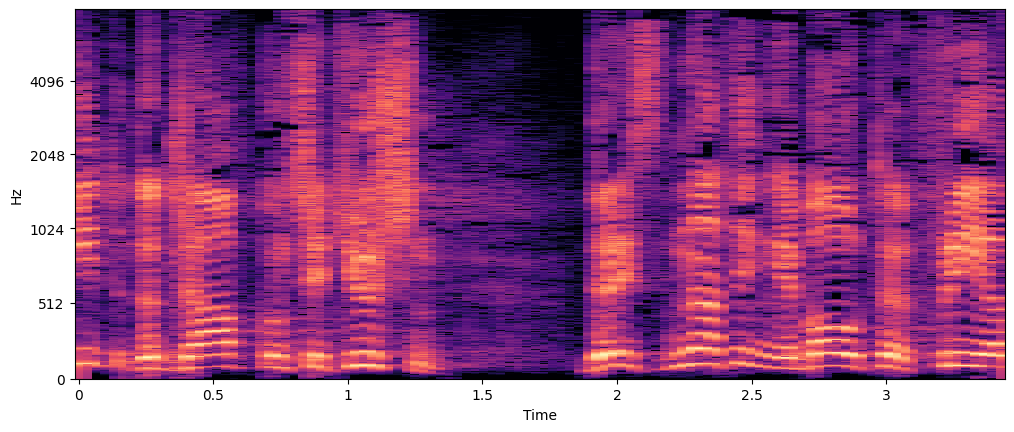

In [ ]:
plt.figure().set_figwidth(12)

entry_audio = third_entry['audio']
librosa.display.waveshow(entry_audio['array'], sr=entry_audio['sampling_rate'])


D = librosa.stft(entry_audio['array'])
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
librosa.display.specshow(S_db, x_axis='time', y_axis='mel', sr=entry_audio['sampling_rate'], fmax=8000)


## 2.4. Transcribe Text

In [ ]:
# Get Model for ASR
asr = pipeline("automatic-speech-recognition", model="openai/whisper-large-v3")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


generation_config.json:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.07k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


preprocessor_config.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

In [ ]:
transcribed_text_from_audio = asr(entry_audio["array"])


Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.


In [ ]:
print (transcribed_text_from_audio['text'])
print (third_entry['normalized_text'])

if (transcribed_text_from_audio['text'] == third_entry['normalized_text']):
  print("Great success!")

# 3. Audio Classification


## 3.1. Load Minds Dataset

In [ ]:
minds = load_dataset("PolyAI/minds14", name="en-AU", split="train")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for PolyAI/minds14 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/PolyAI/minds14
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.w

Generating train split: 0 examples [00:00, ? examples/s]

## 3.2. Load XLS-R Classifier From Checkpoint

In [ ]:
classifier = pipeline(
    "audio-classification",
    model="anton-l/xtreme_s_xlsr_300m_minds14",
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/2.73k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of the model checkpoint at anton-l/xtreme_s_xlsr_300m_minds14 were not used when initializing Wav2Vec2ForSequenceClassification: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at anton-l/xtreme_s_xlsr_300m_minds14 and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos

preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

## 3.3. Run Classification

In [ ]:
classifier(minds[0]["audio"])

[{'score': 0.9611983895301819, 'label': 'pay_bill'},
 {'score': 0.029602158814668655, 'label': 'freeze'},
 {'score': 0.0035503290127962828, 'label': 'card_issues'},
 {'score': 0.002132321475073695, 'label': 'abroad'},
 {'score': 0.000882967549841851, 'label': 'high_value_payment'}]

## 3.4. Load Speech Commands Dataset

In [ ]:
speech_commands = load_dataset(
    "speech_commands", "v0.02", split="validation", streaming=True
)
sample = next(iter(speech_commands))

## 3.5. Load Automatic Speech Transformer Classifier From Checkpoint

In [ ]:
classifier = pipeline(
    "audio-classification", model="MIT/ast-finetuned-speech-commands-v2"
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/342M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/295 [00:00<?, ?B/s]

[{'score': 0.9999892711639404, 'label': 'backward'},
 {'score': 1.7504938796264469e-06, 'label': 'happy'},
 {'score': 6.703033363919531e-07, 'label': 'follow'},
 {'score': 5.805895852972753e-07, 'label': 'stop'},
 {'score': 5.614552378574444e-07, 'label': 'up'}]

## 3.6. Run Classification

In [ ]:
classifier(sample["audio"].copy())

In [ ]:
Audio(sample["audio"]["array"], rate=sample["audio"]["sampling_rate"])

## 3.7. Load Fleurs Dataset

In [ ]:
fleurs = load_dataset("google/fleurs", "all", split="validation", streaming=True)
sample = next(iter(fleurs))

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for google/fleurs contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/google/fleurs
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


## 3.8. Load Whisper Fleurs Classifier From Checkpoint

In [ ]:
# classifier = pipeline(
#     "audio-classification", model="sanchit-gandhi/whisper-medium-fleurs-lang-id"
# )

classifier = pipeline(
     "audio-classification", model="anton-l/xtreme_s_xlsr_300m_fleurs_langid_quicker_warmup"
 )

config.json:   0%|          | 0.00/5.81k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of the model checkpoint at anton-l/xtreme_s_xlsr_300m_fleurs_langid_quicker_warmup were not used when initializing Wav2Vec2ForSequenceClassification: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at anton-l/xtreme_s_xlsr_300m_fleurs_langid_quicker_warmup and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrization

preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

## 3.9. Run Classification

In [ ]:
classifier(sample["audio"])

[{'score': 0.6530705690383911, 'label': 'lv_lv'},
 {'score': 0.15058164298534393, 'label': 'de_de'},
 {'score': 0.07177548110485077, 'label': 'af_za'},
 {'score': 0.02134733647108078, 'label': 'lt_lt'},
 {'score': 0.01586356945335865, 'label': 'nl_nl'}]

## 3.10. One-Shot Classification

### 3.10.1. Load Environmental Speech Challenge Dataset

In [ ]:
dataset = load_dataset("ashraq/esc50", split="train", streaming=True)
audio_sample = next(iter(dataset))["audio"]["array"]

Repo card metadata block was not found. Setting CardData to empty.


### 3.10.2. Set Candidate Labels

In [ ]:
candidate_labels = ["Sound of a dog", "Sound of vacuum cleaner"]

### 3.10.3. Loat Classifier From Checkpoint

In [ ]:
classifier = pipeline(
    task="zero-shot-audio-classification", model="laion/clap-htsat-unfused"
)

### 3.10.4. Run Classification

In [ ]:
classifier(audio_sample, candidate_labels=candidate_labels)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/5.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/615M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

[{'score': 0.9997242093086243, 'label': 'Sound of a dog'},
 {'score': 0.00027583082555793226, 'label': 'Sound of vacuum cleaner'}]

In [ ]:
Audio(audio_sample, rate=16000)

# 4. Music Classification

## 4.1. Load GTZAN Dataset

In [ ]:
from datasets import load_dataset

gtzan = load_dataset("marsyas/gtzan", "all")
gtzan

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for marsyas/gtzan contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/marsyas/gtzan
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'genre'],
        num_rows: 999
    })
})

## 4.2. Split Training Set

In [ ]:
gtzan = gtzan['train'].train_test_split(shuffle=True, test_size = 0.1)
gtzan

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'genre'],
        num_rows: 899
    })
    test: Dataset({
        features: ['file', 'audio', 'genre'],
        num_rows: 100
    })
})

## 4.3. Inspect First Element of Training Set

In [ ]:
entry = gtzan["train"][0]
print(entry)

entry_audio = entry["audio"]
Audio(entry_audio["array"], rate = entry_audio["sampling_rate"])

print (gtzan["train"].features)

# Get genre of dataset entry
entry_int_genre = entry["genre"]
id2label_fn = gtzan["train"].features["genre"].int2str
entry_genre = id2label_fn(entry_int_genre)
print(f"Genre: {entry_genre}")

{'file': '/root/.cache/huggingface/datasets/downloads/extracted/5022b0984afa7334ff9a3c60566280b08b5179d4ac96a628052bada7d8940244/genres/pop/pop.00098.wav', 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/5022b0984afa7334ff9a3c60566280b08b5179d4ac96a628052bada7d8940244/genres/pop/pop.00098.wav', 'array': array([ 0.10720825,  0.16122437,  0.28585815, ..., -0.22924805,
       -0.20629883, -0.11334229]), 'sampling_rate': 22050}, 'genre': 7}
{'file': Value(dtype='string', id=None), 'audio': Audio(sampling_rate=22050, mono=True, decode=True, id=None), 'genre': ClassLabel(names=['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock'], id=None)}
Genre: pop


## 4.4. GRadio Interface

In [ ]:
import gradio as gr

def generate_audio():
    example = gtzan["train"].shuffle()[0]
    audio = example["audio"]
    return (
        audio["sampling_rate"],
        audio["array"],
    ), id2label_fn(example["genre"])


with gr.Blocks() as demo:
    with gr.Column():
        for _ in range(4):
            audio, label = generate_audio()
            output = gr.Audio(audio, label=label)

demo.launch(debug=True)

/usr/local/lib/python3.10/dist-packages/gradio/processing_utils.py:568: UserWarning: Trying to convert audio automatically from float64 to 16-bit int format.
  warnings.warn(warning.format(data.dtype))


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().


KeyboardInterrupt: 

## 4.5. Import Normalizer for Classifier

In [ ]:
model_id = "ntu-spml/distilhubert"
feature_extractor = AutoFeatureExtractor.from_pretrained(
    model_id, do_normalize=True, return_attention_mask=True
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## 4.6. Data Preprocessing

In [ ]:
sampling_rate = feature_extractor.sampling_rate
print(f"Model sampling rate: {sampling_rate}")

dataset_sampling_rate = gtzan["train"][0]["audio"]["sampling_rate"]
print(f"Original dataset sampling rate: {dataset_sampling_rate}")

if (dataset_sampling_rate != sampling_rate):
  gtzan = gtzan.cast_column("audio", DatasetAudio(sampling_rate=sampling_rate))
  dataset_sampling_rate = gtzan["train"][0]["audio"]["sampling_rate"]
  print (f"New dataset sampling rate: {dataset_sampling_rate}")

Model sampling rate: 16000
Original dataset sampling rate: 22050
New dataset sampling rate: 16000


# 4.7. Normalize Dataset for Classification

### 4.7.1. Resampling

In [ ]:
sample = gtzan["train"][0]["audio"]
print(f"Mean: {np.mean(sample['array']):.3}, Variance: {np.var(sample['array']):.3}")

inputs = feature_extractor(sample["array"], sampling_rate=sample["sampling_rate"])

print(f"inputs keys: {list(inputs.keys())}")
print(
    f"Mean: {np.mean(inputs['input_values']):.3}, Variance: {np.var(inputs['input_values']):.3}"
)

Mean: 0.000185, Variance: 0.0493
inputs keys: ['input_values', 'attention_mask']
Mean: -7.45e-09, Variance: 1.0


### 4.7.2. Sample Trimming and Centering

In [ ]:
# Trim audio to 30 second segments
def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=feature_extractor.sampling_rate,
        max_length=int(feature_extractor.sampling_rate * max_duration),
        truncation=True,
        return_attention_mask=True,
    )
    return inputs

max_duration = 30.0
gtzan_encoded = gtzan.map(
    preprocess_function,
    remove_columns=["audio", "file"],
    batched=True,
    batch_size=100,
    num_proc=1,
)
gtzan_encoded

Map:   0%|          | 0/899 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['genre', 'input_values', 'attention_mask'],
        num_rows: 899
    })
    test: Dataset({
        features: ['genre', 'input_values', 'attention_mask'],
        num_rows: 100
    })
})

### 4.7.3. Column Harmonization

In [ ]:
# Rename the genre column to label
gtzan_encoded = gtzan_encoded.rename_column("genre", "label")

# Conversions between numeric and string labels
id2label = {
    str(i): id2label_fn(i)
    for i in range(len(gtzan_encoded["train"].features["label"].names))
}
label2id = {v: k for k, v in id2label.items()}

id2label["7"]

'pop'

## 4.8. Model Training

### 4.8.1. Finetuning

In [ ]:
num_labels = len(id2label)

model = AutoModelForAudioClassification.from_pretrained(
    model_id,
    num_labels=num_labels,
    label2id=label2id,
    id2label=id2label,
)


Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at ntu-spml/distilhubert and are newly initialized: ['classifier.bias', 'classifier.weight', 'encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 4.8.2. Training

In [ ]:
import evaluate
import transformers

model_name = model_id.split("/")[-1]
batch_size = 12
gradient_accumulation_steps = 16
num_train_epochs = 10

# Define the optimizer
optimizer = transformers.AdamW(params=model.parameters(), lr=1e-4)

# Define the total number of training steps and warmup steps
total_steps = 1500
warmup_steps = 100

# Create the scheduler
scheduler = transformers.get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps,
    scheduler_specific_kwargs = {"num_cycles": 3}
)

training_args = TrainingArguments(
    f"{model_name}-finetuned-gtzan",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=9e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    # auto_find_batch_size=True,
    warmup_ratio=0.1,
    logging_steps=5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,
    push_to_hub=True,
)

# Pass the scheduler to training_args
training_args.optimizer = optimizer
training_args.lr_scheduler = scheduler


metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

trainer = Trainer(
    model,
    training_args,
    train_dataset=gtzan_encoded["train"],
    eval_dataset=gtzan_encoded["test"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
)

trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
kwargs = {
    "dataset_tags": "marsyas/gtzan",
    "dataset": "GTZAN",
    "model_name": f"{model_name}-finetuned-gtzan",
    "finetuned_from": model_id,
    "tasks": "audio-classification",
}

if (trainer):
  trainer.push_to_hub=(**kwargs)

# 5. Automatic Speech Recognition

## 5.1. Get Whisper Small

In [ ]:
if torch.cuda.is_available():
    device = "cuda:0"
    torch_dtype = torch.float16
else:
    device = "cpu"
    torch_dtype = torch.float32

pipe = pipeline(
    "automatic-speech-recognition",
    model="openai/whisper-small",
    torch_dtype=torch_dtype,
    device=device,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.87k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

## 5.2. Load the Common Voice 13 Dataset

In [ ]:
common_voice = DatasetDict()
common_voice["test"]  = load_dataset(
    "mozilla-foundation/common_voice_13_0", "sl", split="test"
)
common_voice["train"] = load_dataset(
    "mozilla-foundation/common_voice_13_0", "sl", split="train+validation"
)


## 5.3. Evaluate Model

In [ ]:
from tqdm import tqdm
from transformers.pipelines.pt_utils import KeyDataset

all_predictions = []

# run streamed inference
for prediction in tqdm(
      pipe(
          KeyDataset(common_voice["test"], "audio"),
          max_new_tokens=128,
          generate_kwargs={"task": "transcribe",
                           "language": "sl",},
          batch_size=32,
      ),
      total=len(common_voice["test"]),
  ):
    all_predictions.append(prediction["text"])

100%|██████████| 1240/1240 [00:46<00:00, 26.56it/s]


## 5.4. Compute WER on Raw Audio Prediction

In [ ]:
from evaluate import load

wer_metric = load("wer")

wer_ortho = 100 * wer_metric.compute(
    references=common_voice["test"]["sentence"], predictions=all_predictions
)
wer_ortho

52.41203178206584

## 5.5. Compute WER on Normalized Audio

In [ ]:
from transformers.models.whisper.english_normalizer import BasicTextNormalizer

normalizer = BasicTextNormalizer()

# compute normalised WER
all_predictions_norm = [normalizer(pred) for pred in all_predictions]
all_references_norm = [normalizer(label) for label in common_voice["test"]["sentence"]]

# filtering step to only evaluate the samples that correspond to non-zero references
all_predictions_norm = [
    all_predictions_norm[i]
    for i in range(len(all_predictions_norm))
    if len(all_references_norm[i]) > 0
]
all_references_norm = [
    all_references_norm[i]
    for i in range(len(all_references_norm))
    if len(all_references_norm[i]) > 0
]

wer = 100 * wer_metric.compute(
    references=all_references_norm, predictions=all_predictions_norm
)

wer

49.204997160704146

## 5.6. Keep Input Audio and Transcribed Text for Fine-tuning, Discarding the Additional Metadata Information



In [ ]:
common_voice = common_voice.select_columns(["audio", "sentence"])

## 5.7. Normalize Audio Data

In [ ]:
from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained(
    "openai/whisper-small", language="slovenian", task="transcribe"
)
sampling_rate = processor.feature_extractor.sampling_rate
common_voice = common_voice.cast_column("audio", DatasetAudio(sampling_rate=sampling_rate))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
from transformers.models.whisper.tokenization_whisper import TO_LANGUAGE_CODE

TO_LANGUAGE_CODE

## 5.8. Pre-Process the Data

In [ ]:
def prepare_dataset(example):
    audio = example["audio"]

    example = processor(
        audio=audio["array"],
        sampling_rate=audio["sampling_rate"],
        text=example["sentence"],
    )

    # compute input length of audio sample in seconds
    example["input_length"] = len(audio["array"]) / audio["sampling_rate"]

    return example

common_voice = common_voice.map(
    prepare_dataset, remove_columns=common_voice.column_names["train"], num_proc=1
)

Map:   0%|          | 0/1240 [00:00<?, ? examples/s]

Map:   0%|          | 0/2598 [00:00<?, ? examples/s]

## 5.9. Filter Data Longer Than 30s

In [ ]:
max_input_length = 30.0

def is_audio_in_length_range(length):
    return length < max_input_length

common_voice["train"] = common_voice["train"].filter(
      is_audio_in_length_range,
      input_columns=["input_length"],
  )

common_voice["train"]

Filter:   0%|          | 0/2598 [00:00<?, ? examples/s]

Dataset({
    features: ['input_features', 'labels', 'input_length'],
    num_rows: 2598
})

## 5.10. Add a Data Collator

In [ ]:
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union

class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __init__(self, processor):
        self.processor = processor

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [
            {"input_features": feature["input_features"][0]} for feature in features
        ]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(
            labels_batch.attention_mask.ne(1), -100
        )

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor)

WhisperProcessor:
- feature_extractor: WhisperFeatureExtractor {
  "chunk_length": 30,
  "feature_extractor_type": "WhisperFeatureExtractor",
  "feature_size": 80,
  "hop_length": 160,
  "n_fft": 400,
  "n_samples": 480000,
  "nb_max_frames": 3000,
  "padding_side": "right",
  "padding_value": 0.0,
  "processor_class": "WhisperProcessor",
  "return_attention_mask": false,
  "sampling_rate": 16000
}

- tokenizer: WhisperTokenizer(name_or_path='openai/whisper-small', vocab_size=50258, model_max_length=1024, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>', 'additional_special_tokens': ['<|endoftext|>', '<|startoftranscript|>', '<|en|>', '<|zh|>', '<|de|>', '<|es|>', '<|ru|>', '<|ko|>', '<|fr|>', '<|ja|>', '<|pt|>', '<|tr|>', '<|pl|>', '<|ca|>', '<|nl|>', '<|ar|>', '<|sv|>', '<|it|>', '<|id|>', '<|hi|>', '<|fi|>', '<|vi|>', '<|he|>', '<|uk|>',

## 5.11. Metric Calculator

In [ ]:
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    # compute orthographic wer
    wer_ortho = 100 * metric.compute(predictions=pred_str, references=label_str)

    # compute normalised WER
    pred_str_norm = [normalizer(pred) for pred in pred_str]
    label_str_norm = [normalizer(label) for label in label_str]
    # filtering step to only evaluate the samples that correspond to non-zero references:
    pred_str_norm = [
        pred_str_norm[i] for i in range(len(pred_str_norm)) if len(label_str_norm[i]) > 0
    ]
    label_str_norm = [
        label_str_norm[i]
        for i in range(len(label_str_norm))
        if len(label_str_norm[i]) > 0
    ]

    wer = 100 * wer_metric.compute(predictions=pred_str_norm, references=label_str_norm)

    return {"wer_ortho": wer_ortho, "wer": wer}

## 5.12. Load a Pre-Trained Checkpoint

In [ ]:
from transformers import WhisperForConditionalGeneration
from functools import partial

model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")

# disable cache during training since it's incompatible with gradient checkpointing
model.config.use_cache = False

# set language and task for generation and re-enable cache
model.generate = partial(
    model.generate, language="slovenian", task="transcribe", use_cache=True
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## 5.13. Define Training Configuration and Run Training

In [ ]:
from transformers import Seq2SeqTrainingArguments
from transformers import Seq2SeqTrainer

training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-small-dv",  # name on the HF Hub
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,  # increase by 2x for every 2x decrease in batch size
    learning_rate=1e-5,
    lr_scheduler_type="linear",
    warmup_steps=50,
    max_steps=4000,  # increase to 4000 if you have your own GPU or a Colab paid plan
    gradient_checkpointing=True,
    fp16=True,
    fp16_full_eval=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=16,
    predict_with_generate=True,
    generation_max_length=225,
    save_steps=500,
    eval_steps=500,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=True,
)

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=common_voice["train"],
    eval_dataset=common_voice["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
trainer.train()

In [ ]:
kwargs = {
    "dataset_tags": "mozilla-foundation/common_voice_13_0",
    "dataset": "Common Voice 13",  # a 'pretty' name for the training dataset
    "language": "sl",
    "model_name": "Whisper Small Sl - Cristian Pandele",  # a 'pretty' name for your model
    "finetuned_from": "openai/whisper-small",
    "tasks": "automatic-speech-recognition",
}

## 5.14. Hands-on Exercise

### 5.14.1. Get Whisper Tiny

In [ ]:
if torch.cuda.is_available():
    device = "cuda:0"
    torch_dtype = torch.float16
else:
    device = "cpu"
    torch_dtype = torch.float32

pipe = pipeline(
    "automatic-speech-recognition",
    model="openai/whisper-tiny",
    torch_dtype=torch_dtype,
    device=device,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.75k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

### 5.14.2. Load the Minds-14 Dataset

In [ ]:
minds_dataset = load_dataset("PolyAI/minds14", "en-US")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for PolyAI/minds14 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/PolyAI/minds14
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [ ]:
minds_dataset = minds_dataset['train'].train_test_split(shuffle=False, train_size = 450)
minds_dataset

DatasetDict({
    train: Dataset({
        features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
        num_rows: 450
    })
    test: Dataset({
        features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
        num_rows: 113
    })
})

### 5.14.3. Compute Metrics

In [ ]:
from evaluate import load
from transformers.models.whisper.english_normalizer import BasicTextNormalizer

wer_metric = load("wer")

normalizer = BasicTextNormalizer()

def minds_compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    # compute orthographic wer
    wer_ortho = wer_metric.compute(predictions=pred_str, references=label_str)

    # compute normalised WER
    pred_str_norm = [normalizer(pred) for pred in pred_str]
    label_str_norm = [normalizer(label) for label in label_str]
    # filtering step to only evaluate the samples that correspond to non-zero references:
    pred_str_norm = [
        pred_str_norm[i] for i in range(len(pred_str_norm)) if len(label_str_norm[i]) > 0
    ]
    label_str_norm = [
        label_str_norm[i]
        for i in range(len(label_str_norm))
        if len(label_str_norm[i]) > 0
    ]

    wer = wer_metric.compute(predictions=pred_str_norm, references=label_str_norm)

    return {"wer_ortho": wer_ortho, "wer": wer}

### 5.14.4. Discard Additional Metadata Information


In [ ]:
minds_dataset = minds_dataset.select_columns(["audio", "transcription"])
minds_dataset

DatasetDict({
    train: Dataset({
        features: ['audio', 'transcription'],
        num_rows: 445
    })
    test: Dataset({
        features: ['audio', 'transcription'],
        num_rows: 113
    })
})

### 5.14.5. Pre-Process the Data

In [ ]:
from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained(
    "openai/whisper-small", language="english", task="transcribe"
)
sampling_rate = processor.feature_extractor.sampling_rate
minds_dataset = minds_dataset.cast_column("audio", DatasetAudio(sampling_rate=sampling_rate))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
def prepare_dataset(example):
    audio = example["audio"]

    example = processor(
        audio=audio["array"],
        sampling_rate=audio["sampling_rate"],
        text=example["transcription"],
    )

    example["input_length"] = len(audio["array"]) / audio["sampling_rate"]

    return example

In [ ]:
minds_dataset = minds_dataset.map(
    prepare_dataset, remove_columns=minds_dataset.column_names["train"], num_proc=1
)

Map:   0%|          | 0/445 [00:00<?, ? examples/s]

Map:   0%|          | 0/113 [00:00<?, ? examples/s]

In [ ]:
max_input_length = 30.0

def is_audio_in_length_range(length):
    return length < max_input_length

minds_dataset["train"] = minds_dataset["train"].filter(
      is_audio_in_length_range,
      input_columns=["input_length"],
  )

minds_dataset

Filter:   0%|          | 0/445 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_features', 'labels', 'input_length'],
        num_rows: 445
    })
    test: Dataset({
        features: ['input_features', 'labels', 'input_length'],
        num_rows: 113
    })
})

### 5.14.6. Add Data Collator

In [ ]:
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union

class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __init__(self, processor):
        self.processor = processor

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [
            {"input_features": feature["input_features"][0]} for feature in features
        ]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(
            labels_batch.attention_mask.ne(1), -100
        )

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

minds_collator = DataCollatorSpeechSeq2SeqWithPadding(processor)

### 5.14.7. Load a Pre-Trained Checkpoint

In [ ]:
from transformers import WhisperForConditionalGeneration
from functools import partial

model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny")

# disable cache during training since it's incompatible with gradient checkpointing
model.config.use_cache = False

# set language and task for generation and re-enable cache
model.generate = partial(
    model.generate, language="english", task="transcribe", use_cache=True
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### 5.14.8. Define Training Configuration and Run Training

In [ ]:
from transformers import Seq2SeqTrainingArguments
from transformers import Seq2SeqTrainer

minds_training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-tiny-en",  # name on the HF Hub
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,  # increase by 2x for every 2x decrease in batch size
    learning_rate=1e-5,
    lr_scheduler_type="linear",
    warmup_steps=50,
    max_steps=4000,  # increase to 4000 if you have your own GPU or a Colab paid plan
    gradient_checkpointing=True,
    fp16=True,
    fp16_full_eval=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=16,
    predict_with_generate=True,
    generation_max_length=225,
    save_steps=500,
    eval_steps=500,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=True,
)

minds_trainer = Seq2SeqTrainer(
    args=minds_training_args,
    model=model,
    train_dataset=minds_dataset["train"],
    eval_dataset=minds_dataset["test"],
    data_collator=minds_collator,
    compute_metrics=minds_compute_metrics,
    tokenizer=processor,
)


max_steps is given, it will override any value given in num_train_epochs


In [ ]:
minds_trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50359, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.ut

In [ ]:
from transformers import WhisperForConditionalGeneration
model = WhisperForConditionalGeneration.from_pretrained("cristianpandele/whisper-tiny-en")

kwargs = {
     "dataset_tags": "PolyAI/minds14",
    "finetuned_from": "openai/whisper-tiny",
    "tasks": "automatic-speech-recognition",
}

if (model):
  model.push_to_hub("cristianpandele/whisper-tiny-en", **kwargs)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20

# 6. Text to Speech

## 6.1. Pre-Trained Text to Speech Model 1: SpeechT5Processor

In [ ]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech

processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## 6.2. Tokenize Input

In [ ]:
inputs = processor(text="Don't count the days, make the days count.", return_tensors="pt")

## 6.3. Load Embeddings From CMU Arctic Dataset

In [ ]:
embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")

speaker_embeddings = embeddings_dataset[7306]["xvector"]
speaker_embeddings = torch.tensor(speaker_embeddings).unsqueeze(0)

Generating validation split:   0%|          | 0/7931 [00:00<?, ? examples/s]

## 6.4. Generate Output Spectrogram

In [ ]:
spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings)

## 6.5. Get Vocoder Model

In [ ]:
from transformers import SpeechT5HifiGan
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")


config.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/50.7M [00:00<?, ?B/s]

## 6.6. Use Vocoder to Convert Spectrogram to Audio

In [ ]:
speech = model.generate_speech(inputs["input_ids"], speaker_embeddings, vocoder=vocoder)
Audio(speech, rate=16000)

## 6.7. Pre-Trained Text to Speech Model 2: Bark

In [ ]:
from transformers import BarkModel, BarkProcessor

model = BarkModel.from_pretrained("suno/bark-small")
processor = BarkProcessor.from_pretrained("suno/bark-small")


config.json:   0%|          | 0.00/8.80k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
/usr/local/lib/python3.10/dist-packages/transformers/models/encodec/modeling_encodec.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("padding_total", torch.tensor(kernel_size - stride, dtype=torch.int64), persistent=False)


generation_config.json:   0%|          | 0.00/4.91k [00:00<?, ?B/s]

speaker_embeddings_path.json:   0%|          | 0.00/61.1k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/353 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

## 6.8. Test Embedding

In [ ]:
# add a speaker embedding
inputs = processor("This is a test!", voice_preset="v2/en_speaker_3")

speech_output = model.generate(**inputs).cpu().numpy()

sampling_rate = model.generation_config.sample_rate
Audio(speech_output, rate=sampling_rate)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:10000 for open-end generation.


In [ ]:
# try it in French, let's also add a French speaker embedding
inputs = processor("C'est un test!", voice_preset="v2/fr_speaker_1")

speech_output = model.generate(**inputs).cpu().numpy()

sampling_rate = model.generation_config.sample_rate
Audio(speech_output, rate=sampling_rate)

fr_speaker_1_semantic_prompt.npy:   0%|          | 0.00/2.62k [00:00<?, ?B/s]

fr_speaker_1_coarse_prompt.npy:   0%|          | 0.00/7.60k [00:00<?, ?B/s]

fr_speaker_1_fine_prompt.npy:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:10000 for open-end generation.


In [ ]:
inputs = processor(
    "[clears throat] This is a test ... and I just took a long pause.",
    voice_preset="v2/fr_speaker_1",
)

speech_output = model.generate(**inputs).cpu().numpy()

sampling_rate = model.generation_config.sample_rate
Audio(speech_output, rate=sampling_rate)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:10000 for open-end generation.


In [ ]:
inputs = processor(
    "♪ In the mighty jungle, I'm trying to generate barks.",
)

speech_output = model.generate(**inputs).cpu().numpy()

sampling_rate = model.generation_config.sample_rate
Audio(speech_output, rate=sampling_rate)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:10000 for open-end generation.


## 6.9. Pre-Trained Text to Speech Model 3: Massive Multilingual Speech

In [ ]:
from transformers import VitsModel, VitsTokenizer

model = VitsModel.from_pretrained("facebook/mms-tts-deu")
tokenizer = VitsTokenizer.from_pretrained("facebook/mms-tts-deu")


config.json:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/145M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/mms-tts-deu were not used when initializing VitsModel: ['flow.flows.0.wavenet.in_layers.0.weight_g', 'flow.flows.0.wavenet.in_layers.0.weight_v', 'flow.flows.0.wavenet.in_layers.1.weight_g', 'flow.flows.0.wavenet.in_layers.1.weight_v', 'flow.flows.0.wavenet.in_layers.2.weight_g', 'flow.flows.0.wavenet.in_layers.2.weight_v', 'flow.flows.0.wavenet.in_layers.3.weight_g', 'flow.flows.0.wavenet.in_layers.3.weight_v', 'flow.flows.0.wavenet.res_skip_layers.0.weight_g', 'flow.flows.0.wavenet.res_skip_layers.0.weight_v', 'flow.flows.0.wavenet.res_skip_layers.1.weight_g', 'flow.flows.0.wavenet.res_skip_layers.1.weight_v', 'flow.flows.0.wavenet.res_skip_layers.2.weight_g', 'flow.flows.0.wavenet.res_skip_layers.2.weight_v', 'flow.flows.0.wavenet.res_skip_layers.3.weight_g', 'flow.flows.0.wavenet.res_skip_layers.3.weight_v', 'flow.flows.1.wavenet.in_layers.0.weight_g', 'flow.flows.1.wavenet.in_layers.0.weight_v', 'flow.flows.1.wavenet.in_layers.1.wei

tokenizer_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/496 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/47.0 [00:00<?, ?B/s]

## 6.10 Generate Output

In [ ]:
text_example = (
    "Ich bin Schnappi das kleine Krokodil, komm aus Ägypten das liegt direkt am Nil."
)

inputs = tokenizer(text_example, return_tensors="pt")
input_ids = inputs["input_ids"]


with torch.no_grad():
    outputs = model(input_ids)

speech = outputs["waveform"]

Audio(speech, rate=16000)

## 6.11. Hands-On Exercise Fine-tune T5

### 6.11.1. Load the Vox Populi Dataset - Change Language From Example

In [57]:
dataset = load_dataset("facebook/voxpopuli", "lt", split="train")
len(dataset)


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

456

### 6.11.2. Get the TTS Model From Checkpoint

In [58]:
from transformers import SpeechT5Processor

checkpoint = "microsoft/speecht5_tts"
processor = SpeechT5Processor.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### 6.11.3. Preprocess the Data

In [59]:
dataset = dataset.cast_column("audio", DatasetAudio(sampling_rate=16000))

# Get the tokenizer
tokenizer = processor.tokenizer

# Inspect an entry of the dataset
dataset[0]

{'audio_id': '20191217-0900-PLENARY-lt_20191217-22:09:06_1',
 'language': 15,
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/8dc91c9a5ed921d4272af3113bda7975b8963b56caf0f500ed02bdd7c69d1177/train_part_0/20191217-0900-PLENARY-lt_20191217-22:09:06_1.wav',
  'array': array([0.02304077, 0.03216553, 0.02148438, ..., 0.00292969, 0.01467896,
         0.01254272]),
  'sampling_rate': 16000},
 'raw_text': 'Skaitmeninės sveikatos priežiūros sistema suteikia galimybės plėtoti dirbtinio intelekto bei kompiuterinio mokymosi panaudojimą. Naujos technologijos pritaikytos sveikatos priežiūros sistemai gali padėti geriau suprasti sunkiai pagydomas ligas bei kitus sveikatos sutrikimus.',
 'normalized_text': 'skaitmeninės sveikatos priežiūros sistema suteikia galimybės plėtoti dirbtinio intelekto bei kompiuterinio mokymosi panaudojimą. naujos technologijos pritaikytos sveikatos priežiūros sistemai gali padėti geriau suprasti sunkiai pagydomas ligas bei kitus sveikatos sutrikimu

6.11.4. Normalize Characters

In [62]:
def extract_all_chars(batch):
    all_text = " ".join(batch["normalized_text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}

vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset.column_names,
)

# Get a set of all characters in dataset
dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k, _ in tokenizer.get_vocab().items()}

# Get diff between dataset and tokenizer supported characters
dataset_diff = dataset_vocab - tokenizer_vocab

print (dataset_diff)

Map:   0%|          | 0/456 [00:00<?, ? examples/s]

{'ą', 'į', 'ų', 'ū', 'č', ' ', 'š', 'ž', 'ė', 'ę'}


In [63]:
replacements = [
    ("ą", "a"),
    ("į", "c"),
    ("ų", "e"),
    ("ū", "e"),
    ("š", "s"),
    ("ž", "z"),
    ("ė", "e"),
    ("ę", "e"),
]


def cleanup_text(inputs):
    for src, dst in replacements:
        inputs["normalized_text"] = inputs["normalized_text"].replace(src, dst)
    return inputs

# Cleanup dataset characters
dataset = dataset.map(cleanup_text)

Map:   0%|          | 0/456 [00:00<?, ? examples/s]

### 6.11.5. Dataset Exploration

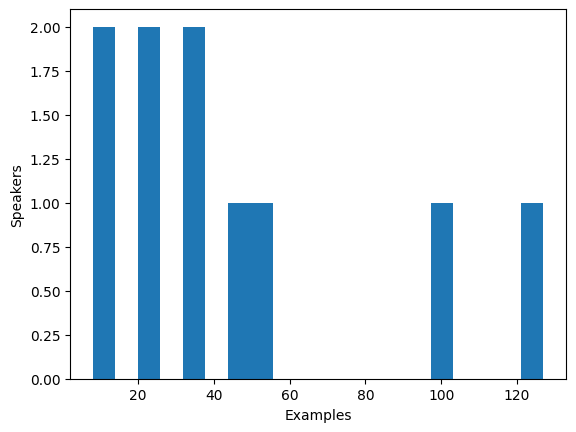

In [64]:
from collections import defaultdict
speaker_counts = defaultdict(int)

# Histogram of speaker occurence in dataset
for speaker_id in dataset["speaker_id"]:
    speaker_counts[speaker_id] += 1

import matplotlib.pyplot as plt

plt.figure()
plt.hist(speaker_counts.values(), bins=20)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()

### 6.11.6. Keep Speakers With 100...400 Entries

In [ ]:
def select_speaker(speaker_id):
    return 100 <= speaker_counts[speaker_id] <= 400


dataset = dataset.filter(select_speaker, input_columns=["speaker_id"])

print(len(set(dataset["speaker_id"])))

print(len(dataset))

Filter:   0%|          | 0/9973 [00:00<?, ? examples/s]

42
9973


### 6.11.7. Generate Speaker Embeddings

In [65]:
import os
from speechbrain.inference.classifiers import EncoderClassifier

spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name),
)


def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

### 6.11.8. Process the Data by Tokenizing Input Text

In [66]:
def prepare_dataset(example):
    audio = example["audio"]

    example = processor(
        text=example["normalized_text"],
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])

    return example

# Verify correct processing by applying to single entry
processed_example = prepare_dataset(dataset[0])

print(list(processed_example.keys()))

print(processed_example["speaker_embeddings"].shape)

['input_ids', 'labels', 'speaker_embeddings']
(512,)


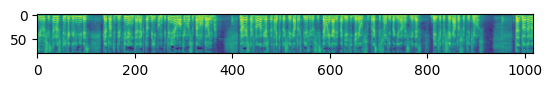

In [67]:
### Display Spectrogram
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

In [68]:
# Apply to Entire Dataset
dataset = dataset.map(prepare_dataset, remove_columns=dataset.column_names)


Map:   0%|          | 0/456 [00:00<?, ? examples/s]

In [45]:
# Remove Token Sequences Over 200 Tokens
def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 200


dataset = dataset.filter(is_not_too_long, input_columns=["input_ids"])
len(dataset)

Filter:   0%|          | 0/9973 [00:00<?, ? examples/s]

8259

### 6.11.9. Split Training Set

In [70]:
dataset = dataset.train_test_split(test_size=0.1)
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 410
    })
    test: Dataset({
        features: ['input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 46
    })
})

6.11.9. Data Collator

In [71]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union


class TTSDataCollatorWithPadding:
    processor: Any

    def __init__(self, processor):
        self.processor = processor

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids, labels=label_features, return_tensors="pt"
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor(
                [len(feature["input_values"]) for feature in label_features]
            )
            target_lengths = target_lengths.new(
                [
                    length - length % model.config.reduction_factor
                    for length in target_lengths
                ]
            )
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

data_collator = TTSDataCollatorWithPadding(processor=processor)

### 6.11.10. Train the Model

In [72]:
from transformers import SpeechT5ForTextToSpeech

model = SpeechT5ForTextToSpeech.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [73]:
# use_cache=True option is incompatible with gradient checkpointing.
# Disable it for training, and re-enable cache for generation to speed-up inference time

from functools import partial

# disable cache during training since it's incompatible with gradient checkpointing
model.config.use_cache = False

# set language and task for generation and re-enable cache
model.generate = partial(model.generate, use_cache=True)


In [76]:
# Define the training arguments.
# Here we are not computing any evaluation metrics during the training process, we’ll talk about evaluation later in this chapter. Instead, we’ll only look at the loss

from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="speecht5_finetuned_voxpopuli_lt",  # change to a repo name of your choice
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=4000,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=2,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=True,
)

from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=processor,
)

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1876}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be raised to an exception in v4.41.
/usr/local/lib/python3.10/dist-packages/torch/utils/che

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1876}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be raised to an exception in v4.41.
/usr/local/lib/python3.10/dist-packages/torch/utils/che

In [ ]:
trainer.push_to_hub()

In [ ]:
kwargs = {
    "dataset_tags": "facebook/voxpopuli",
    "finetuned_from": "microsoft/speecht5_tts",
    "tasks": "text-to-speech",
    "model_name": "speecht5_finetuned_voxpopuli_lt",
}


trainer.push_to_hub(**kwargs)
